# Census Income Prediction

https://www2.census.gov/programs-surveys/cps/techdocs/cpsmar94.pdf#

In [1]:
import urllib.request
import shutil
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from pathlib import Path
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

### Load Data

In [2]:
PROJECT_PATH = Path('/home/ubuntu/flatworld/')
DATA_DIR = PROJECT_PATH / 'data'

In [3]:
with (DATA_DIR / 'census_income_metadata.txt').open('r') as fin:
    metadata_desc = fin.read()
metadata = metadata_desc.split('|')
metadata = [md.strip() for md in metadata][1:]

In [4]:
col_info = [xx for xx in metadata if 'attribute #' in xx]

col_distinct = [int(col.split(' ')[0]) for col in col_info]
col_nums = [int(xx.split('#')[1][:2]) for xx in col_info]
col_types = [col[(col.find(')') + 2):] for col in col_info]
col_names = [col[col.find('(')+1:col.find(')')] for col in col_info]
# NOTE: Having chosen to pull column names from these lines was a bit unfortunate because
#  the 24th entry in the csv is actually the instance weight as shown in lines 24-68 of
#  the metadata text file. This is skipped over in these lines, so attribute # doesn't
#  actually correspond to column location in the csv. Seems like this should be
#  pointed out more explicitly somewhere in the file.

col_info_df = pd.DataFrame([xx for xx in zip(col_names, col_types, col_distinct)], columns=['col_names', 'col_type', 'col_distinct'], index=col_nums)
cont_cols = col_info_df[col_info_df['col_type'] == 'continuous']['col_names'].values
nom_cols = col_info_df[col_info_df['col_type'] == 'nominal']['col_names'].values
col_info_df.head()

,col_names,col_type,col_distinct
0,age,continuous,91
1,class of worker,nominal,9
2,detailed industry recode,nominal,52
3,detailed occupation recode,nominal,47
4,education,nominal,17


In [5]:
# Build column name mapper
idxs = [xx for xx in range(42)]
idxs.pop(24)
idxs
col_names.append('target')
col_name_map = dict(zip(idxs, col_names))

In [6]:
census_df = pd.read_csv(DATA_DIR / 'census_income_learn.csv',header=None)
instance_weights = census_df.pop(24) # Remove instance weights
census_df.rename(columns=col_name_map, inplace=True)
census_df.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [7]:
# Clean up string values which have leading/trailing spaces
for col in col_names:
    try:
        census_df[col] = census_df[col].apply(lambda x: x.strip())
    except:
        pass

###  Inspect Metadata statistics

In [8]:
col_info_df.sort_values('col_distinct', ascending=False)

,col_names,col_type,col_distinct
18,dividends from stocks,continuous,1478
5,wage per hour,continuous,1240
16,capital gains,continuous,132
17,capital losses,continuous,113
0,age,continuous,91
38,weeks worked in year,continuous,53
2,detailed industry recode,nominal,52
21,state of previous residence,nominal,51
3,detailed occupation recode,nominal,47
31,country of birth father,nominal,43


##### Thoughts:

1. The main issue that pops out to me here is the difficulty in **dealing with nominal (categorical) data that has a large number of categories**.
    * This is because when working with categorical data we typically preprocess the data by converting the single column with $N$ distinct values into $N$ columns which are binary encoded. e.g. if we have a column $\texttt{gender}$ with values $[\texttt{gender}] \in [\{\texttt{male, female, other}\}]$, then we map this column to three columns $[\texttt{gender}] \rightarrow [\texttt{gender_male, gender_female, gender_other}] \in [\{0, 1\}, \{0, 1\}, \{0, 1\}]$. However, for features with a large number of possible values this can cause the dimension of our feature space to increase dramatically.
    * A first approach to handle this type of issue is to simply try to ignore this dimension and see if the model performs adequately without it. This is what I will do now, but I imagine that this will be sub-optimal as some of these high-dimensional features contain superfically relevant information, e.g. indusrty and occupation codes. ***More on this below.***

In [9]:
# If we naively applied this methodology the dimension of our feature space would increase from 40 to
# such a large number it causes an integer overflow to calculate it
n_nom_cols_cart_prod = col_info_df[col_info_df['col_type'] == 'nominal']['col_distinct'].sum()
n_cont_cols = col_info_df[col_info_df['col_type'] == 'continuous'].shape[0]
print('Dimensionality of naive feature space would be {}'.format(n_nom_cols_cart_prod + n_cont_cols))

Dimensionality of naive feature space would be 510


In [10]:
# # Download supplementary files from web
# urls = [
#     'https://www.census.gov/eos/www/naics/2002NAICS/2002_Definition_File.pdf',
#     'https://www.census.gov/eos/www/naics/reference_files_tools/2002/naics_2_6_02.txt'
# ]
# file_names = [
#     '2002_Definition_File.pdf',
#     'naics_2_6_02.txt'
# ]
# for url, file_name in zip(urls, file_names):
#     with urllib.request.urlopen(url) as response, open(DATA_DIR / file_name, 'wb') as out_file:
#         shutil.copyfileobj(response, out_file)

2. Though the data was categorized into $[\texttt{Data}] = [\texttt{continuous}] \otimes [\texttt{nominal}]$, this decomposition is perhaps a bit too coarse. **Nominal data assumes that there is no natural metric relationship between the categories, but this is not necessarily true, e.g. geographical data**, populations in nearby locations are more likely to be similar than between more distant locations.
    * ***Should be safe to ignore this additional information***, but should be kept in mind when it comes time to optimize the model.

### Inspect data for any obvious quality issues

In [11]:
# Check for nulls
census_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
age                                           199523 non-null int64
class of worker                               199523 non-null object
detailed industry recode                      199523 non-null int64
detailed occupation recode                    199523 non-null int64
education                                     199523 non-null object
wage per hour                                 199523 non-null int64
enroll in edu inst last wk                    199523 non-null object
marital stat                                  199523 non-null object
major industry code                           199523 non-null object
major occupation code                         199523 non-null object
race                                          199523 non-null object
hispanic origin                               199523 non-null object
sex                                           199523 non-null obj

#### Inspect continuous data

In [12]:
# Check continuously valued columns
census_df[sorted(cont_cols)].describe()

,age,capital gains,capital losses,dividends from stocks,num persons worked for employer,wage per hour,weeks worked in year
count,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,434.71899,37.313788,197.529533,1.956180,55.426908,23.174897
std,22.310895,4697.53128,271.896428,1984.163658,2.365126,274.896454,24.411488
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.00000,0.000000,0.000000,1.000000,0.000000,8.000000
75%,50.000000,0.00000,0.000000,0.000000,4.000000,0.000000,52.000000
max,90.000000,99999.00000,4608.000000,99999.000000,6.000000,9999.000000,52.000000


In [13]:
def compare_hist(field, thresh=0, bins=25, sharex=True, sharey=True):
    """Plots three histograms representing the total population, the ones making over 50000,
       and those making below 50000.
       
       args:
         field - which continuous feature to plot
         thresh - arbitrary threshold to set on field to clean up visualization
         bins - number of bins
         sharex - equalize x-axes in plots
         sharey - equalize y-axes in plots
    """
    colors = {
        'tot': '#5D3A72',
        'pos': '#A85153',
        'neg': '#4B5872'
    }
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=sharex, sharey=sharey)
    ax[0].hist(census_df[census_df[field] > thresh][field].values , bins=bins, color=colors['tot'], label='Total')
    ax[1].hist(census_df[(census_df[field] > thresh) & (census_df['target'] == '50000+.')][field].values, bins=bins, color=colors['pos'], label='>50000')
    ax[2].hist(census_df[(census_df[field] > thresh) & (census_df['target'] == '- 50000.')][field].values, bins=bins, color=colors['neg'], label='<50000')
    [a.legend(loc='upper right') for a in ax]
    ax[0].set_ylabel(field)
    fig.show()

##### age

/home/ubuntu/flatworld/flatworld_env/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


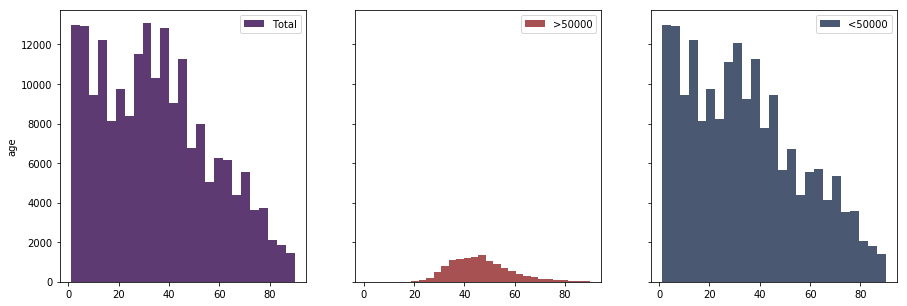

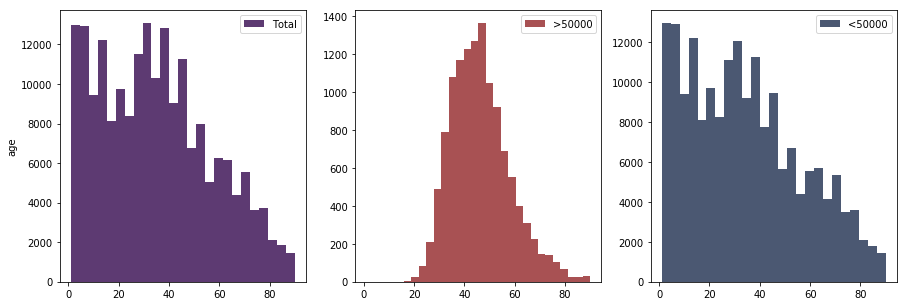

In [14]:
compare_hist('age')
compare_hist('age', sharey=False)

* No obvious signs of quality issues
* Negative population statistics seems to mirror total population
* Positive population seems normally distributed about ~50

##### capital gains

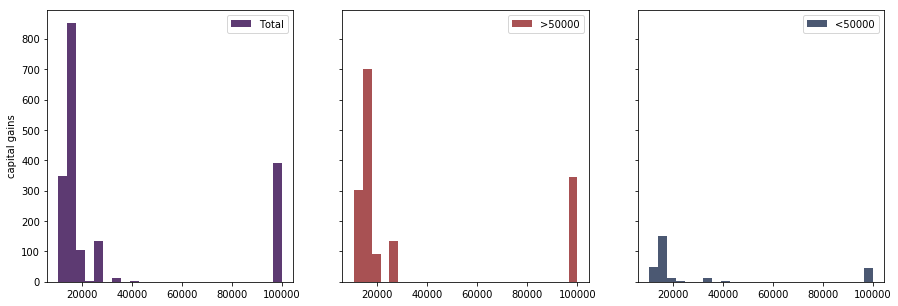

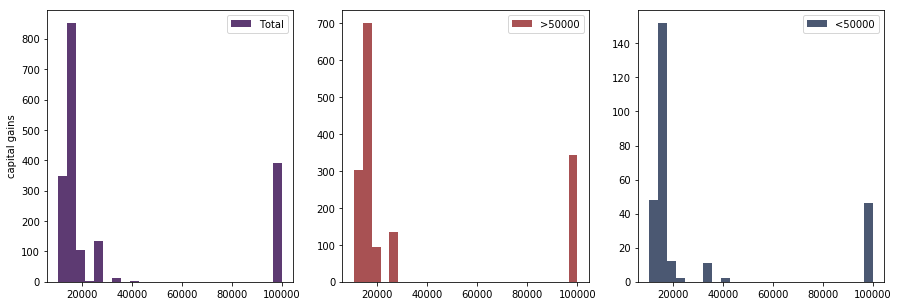

In [15]:
compare_hist('capital gains', 10000.0)
compare_hist('capital gains', 10000.0, sharey=False)

* No obvious quality issues
* Both positive and negative group statistics seem similar to total statistics
* Slight preponderance of very large capital gains in positive group, which makes sense

##### capital losses

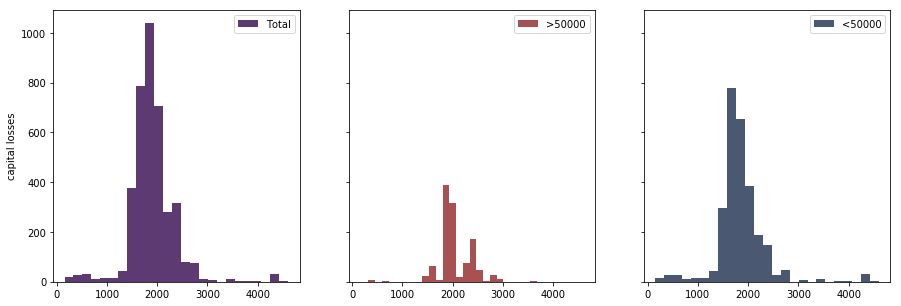

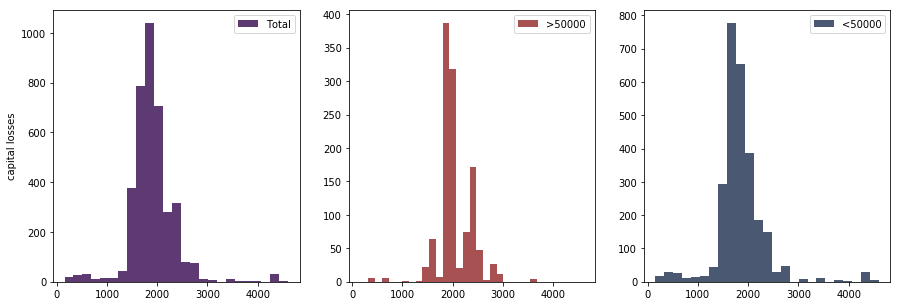

In [16]:
compare_hist('capital losses', 100.0)
compare_hist('capital losses', 100.0, sharey=False)

* No obvious quality issues
* Positive and negative statistics seem similar to total statistics
* Interestingly, there seems to be a very slight over-representation of large capital losses in the negative group than in the over. This seems plausible, but the signal is so slight, I doubt it would stand up to rigorous statistical tests.

##### dividends from stocks

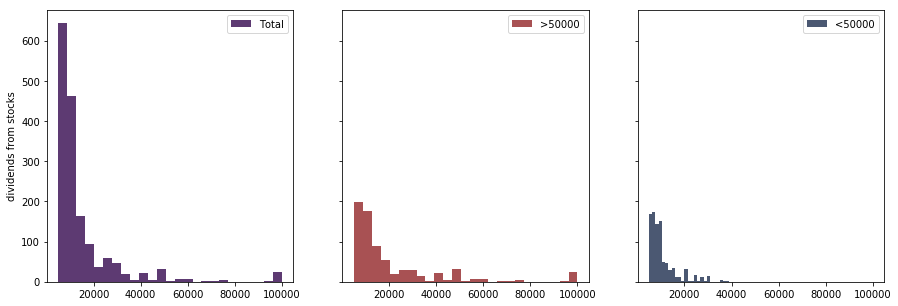

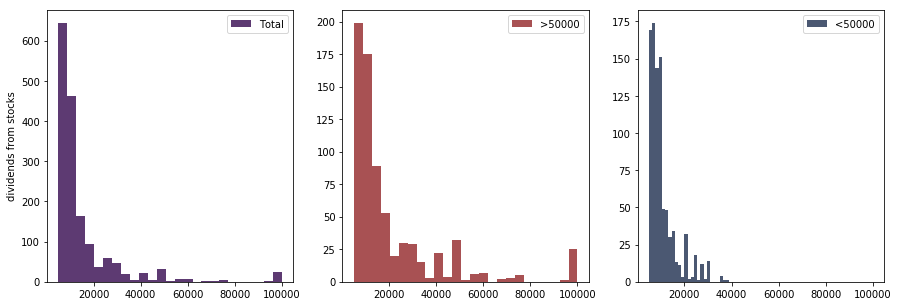

In [17]:
compare_hist('dividends from stocks', 5000.0)
compare_hist('dividends from stocks', 5000.0, sharey=False)

* No obvious quality issues
* Positive and negative statistics seem mostly similar to total statistics
* (Nearly) all of those that had very large stock dividends were in the positive group, which makes sense

##### num persons worked for employer

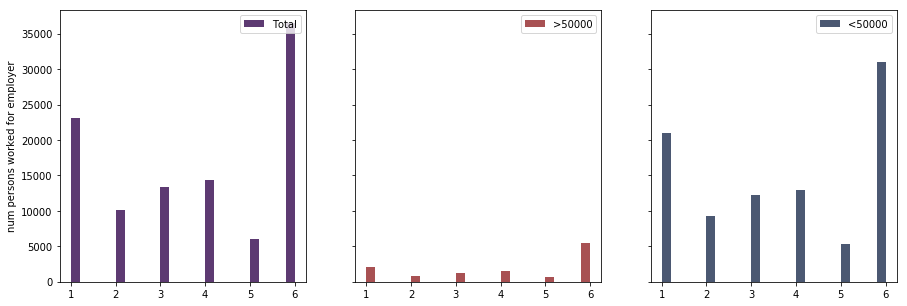

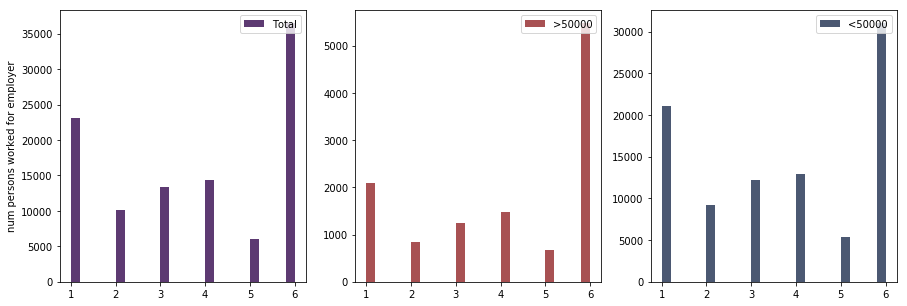

In [18]:
compare_hist('num persons worked for employer')
compare_hist('num persons worked for employer', sharey=False)

* No obvious quality issues
* Positive and negative statistics seem mostly similar to total statistics
* It seems that those in the positive group were more likely to work for a large company (category 6: >1000 employees) than a small company (category 1: <10 employees). Which seems reasonable.

##### wage per hour

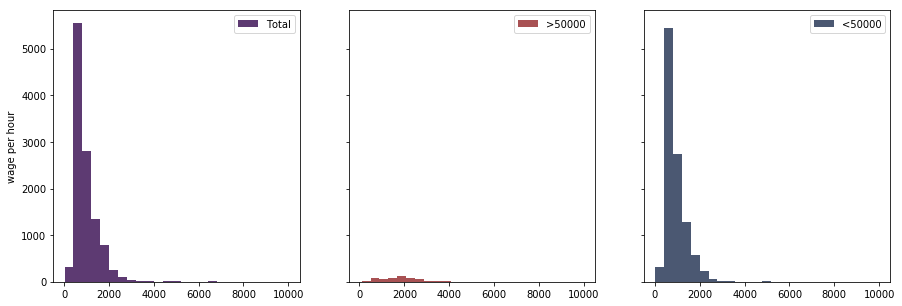

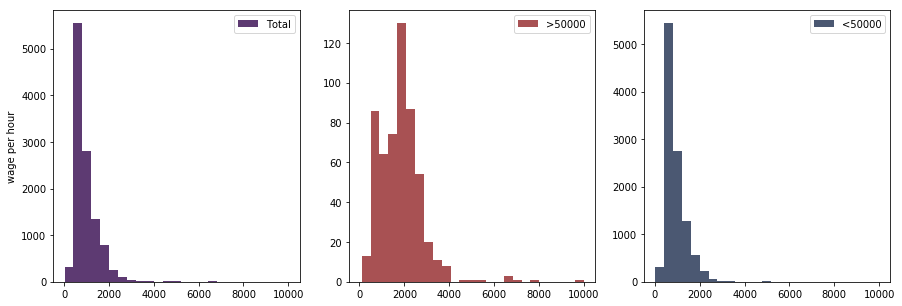

In [19]:
compare_hist('wage per hour')
compare_hist('wage per hour', sharey=False)

* No obvious quality issues
* Positive statistics seem very slightly more normally distributed, whereas negative group much more heavy tailed
* **Seems like a Maxwell-Boltzman distribution, which, in analogy to physics, describes the distributions of speed in a gas. In this analogy it would seem that the group making above 50000 have a higher "temperature" or a lower "mass", which could be interpreted as those employees work in industries which have more money to spend on wages (higher temp - more energy to spread around), or have backgrounds/skills that make them easier to promote from low paying jobs to high paying jobs (low mass - easy to accelerate).**

##### weeks worked in year

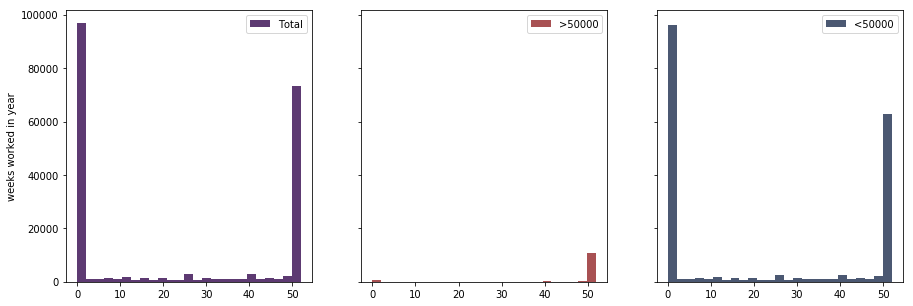

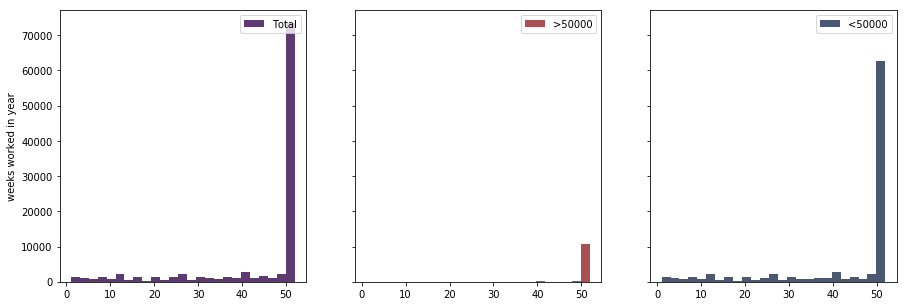

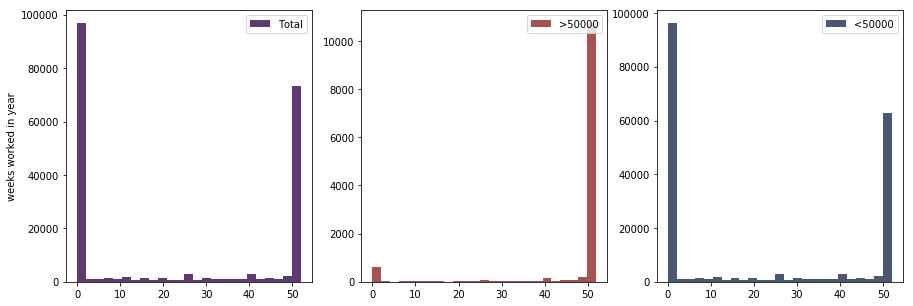

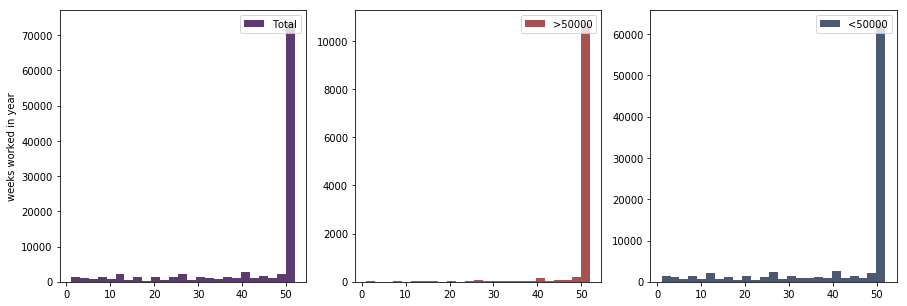

In [20]:
compare_hist('weeks worked in year', -0.01)
compare_hist('weeks worked in year', 0.0)                    # Ignore contribution from those unemployed all year
compare_hist('weeks worked in year', -0.01, sharey=False)
compare_hist('weeks worked in year', 0.0, sharey=False)      # Ignore contribution from those unemployed all year

* No obvious quality issues
* Not surprisingly, those making above 50000 are almost entirely employed all year, but interestingly there are a few hundred making above 50000 and not employed all year. (Must be nice :/ ...)
* Those making below 50000 make up almost the entire population of unemployed and also have almost all of the variation in employment levels.

In [21]:
# Just to be safe, view raw value counts for each feature to look for invalid values
for col in cont_cols:
    print('{:-^30s}'.format(' ' + col + ' '))
    print(census_df[col].value_counts().sort_index())
    print('\n')

------------ age -------------
0     2839
1     3138
2     3236
3     3279
4     3318
5     3332
6     3171
7     3218
8     3187
9     3162
10    3134
11    3128
12    3060
13    3152
14    3068
15    2926
16    2882
17    2762
18    2484
19    2419
20    2390
21    2386
22    2573
23    2789
24    2783
      ... 
66    1443
67    1496
68    1436
69    1412
70    1410
71    1418
72    1315
73    1354
74    1227
75    1065
76    1050
77     979
78     876
79     811
80     799
81     720
82     615
83     561
84     519
85     423
86     348
87     301
88     241
89     195
90     725
Name: age, Length: 91, dtype: int64


------- wage per hour --------
0       188219
20           1
70           1
75           2
100         11
110          1
125          1
135          1
143          1
150          6
170          1
173          1
190          1
200         27
205          1
210          7
212          2
213         20
215          3
220          2
225          4
230          1
232      

#### Inspect Nominal Data

In [22]:
nom_cols_less = col_info_df[(col_info_df['col_type'] == 'nominal') & (col_info_df['col_distinct'] < 30)]['col_names'].values
nom_cols_less

array(['class of worker', 'education', 'enroll in edu inst last wk',
       'marital stat', 'major industry code', 'major occupation code',
       'race', 'hispanic origin', 'sex', 'member of a labor union',
       'reason for unemployment', 'full or part time employment stat',
       'tax filer stat', 'region of previous residence',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'family members under 18',
       'citizenship', 'own business or self employed',
       "fill inc questionnaire for veteran's admin", 'veterans benefits',
       'year'], dtype=object)

In [23]:
def compare_bar_nom(field,sharex=True, sharey=True):
    """Plots three bar charts representing the total population, the ones making over 50000,
       and those making below 50000.
       
       args:
         field - which continuous feature to plot
         sharex - equalize x-axes in plots
         sharey - equalize y-axes in plots
    """
    colors = {
        'tot': '#5D3A72',
        'pos': '#A85153',
        'neg': '#4B5872'
    }
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=sharex, sharey=sharey)
    tot = census_df[field].value_counts(dropna=False).sort_index().fillna(0)
    neg = census_df[census_df['target'] == '- 50000.'][field].value_counts(dropna=False).sort_index().fillna(0)
    pos = census_df[census_df['target'] == '50000+.'][field].value_counts(dropna=False).sort_index().fillna(0)
    full = pd.DataFrame({'tot': tot, 'pos': pos, 'neg':neg})
    idx = np.arange(0, tot.shape[0])
    ax[0].bar(idx, list(full['tot'].values), tick_label=list(full['tot'].keys()), color=colors['tot'], label='Total')
    ax[1].bar(idx, list(full['pos'].values), tick_label=list(full['pos'].keys()), color=colors['pos'], label='>50000')
    ax[2].bar(idx, list(full['neg'].values), tick_label=list(full['neg'].keys()), color=colors['neg'], label='<50000')
    for a in ax:
        a.legend(loc='upper right')
        for tick in a.get_xticklabels():
            tick.set_rotation(90)
    ax[0].set_ylabel(field)
    plt.show()
    plt.close()

In [24]:
# # Show bar chart distributions for all nominal data fields
# # Warning: Takes a while to load
# for col in sorted(nom_cols):
#     print('#' * 80)
#     print('{:#^80s}'.format(' ' + col + ' '))
#     print('#' * 80)
#     compare_bar_nom(col)
#     compare_bar_nom(col, sharey=False)

In [25]:
# View raw value counts for each nominal feature to look for invalid values
for col in nom_cols:
    print('{:-^30s}'.format(' ' + col + ' '))
    print(census_df[col].value_counts().sort_index())
    print('\n')

------ class of worker -------
Federal government                  2925
Local government                    7784
Never worked                         439
Not in universe                   100245
Private                            72028
Self-employed-incorporated          3265
Self-employed-not incorporated      8445
State government                    4227
Without pay                          165
Name: class of worker, dtype: int64


-- detailed industry recode --
0     100684
1        827
2       2196
3        563
4       5984
5        553
6        554
7        422
8        550
9        993
10         4
11      1764
12      1350
13       899
14       295
15       452
16       539
17       157
18       483
19      1346
20        32
21       559
22       952
23       525
24      1503
       ...  
27       626
28       143
29      4209
30      1181
31      1178
32      3596
33     17070
34      2765
35      3380
36       945
37      4022
38      1629
39      2937
40      1651
41      396

Child 18 or older                       14430
Child under 18 ever married                47
Child under 18 never married            50426
Group Quarters- Secondary individual      132
Householder                             75475
Nonrelative of householder               7601
Other relative of householder            9703
Spouse of householder                   41709
Name: detailed household summary in household, dtype: int64


 migration code-change in msa 
?                   99696
Abroad to MSA         453
Abroad to nonMSA       73
MSA to MSA          10601
MSA to nonMSA         790
NonMSA to MSA         615
NonMSA to nonMSA     2811
Nonmover            82538
Not identifiable      430
Not in universe      1516
Name: migration code-change in msa, dtype: int64


 migration code-change in reg 
?                                 99696
Abroad                              530
Different county same state        2797
Different division same region      465
Different region                   11

In the interest of time, I can't go through each of these in as much detail as I did above for the continuous values. Depending on the timeline of the project and number of features in the datasey, I would do generally like to do this. However, below I note just a few interesting points:
* A few data fields have '?' entries - these need to be cleaned.
* **citizenship**: Foreigners who became US citizens are more prevalent at higher incomes - which makes sense from an talent acquisition standpoint.
* **class of worker**: Self-employed corporated workers are more prevalent at higher incomes
* **detailed household summary in household**: Those making above 50000 are much more likely to be the householder as opposed to those below 50000.
* **detailed industry/occupation recode**: much more variation in industry/occupation for those above 50000
* **education**: education level is skewed towards more advanced degrees for those making above 50000, which certainly makes sense.
* **enroll in edu inst last wk** - seems irrelevant
* **family members under 18** - due to preponderance of "Not in universe" - this field will likley be irrelevant.
* **full or part time employment stat** - relatively more full-time at high incomes
* **hispanic origin** - much more represented in the below 50000 group.
* **live in this house 1 year ago** - above 50000 are slightly more stationary
* **major occupation code** - more executives above 50000
* **marital stat** - above 50000 much more likely to be married
* **race** - minorities far less represented above 50000
* **sex** - very clear imbalance between the genders
* **tax filer stat** - those making more money almost certainly file their taxes
* **veterans benefits** - seem to have an effect, but it's unclear what the categories represent

### Decide which columns to drop & how to clean

##### Clean up ?'s

In [26]:
has_qms = [col for col in nom_cols if '?' in census_df[col].value_counts().index]
frac_qms = {col: census_df[col].value_counts(normalize=True)['?'] for col in has_qms}
frac_qms

{'state of previous residence': 0.003548463084456429,
 'migration code-change in msa': 0.4996717170451527,
 'migration code-change in reg': 0.4996717170451527,
 'migration code-move within reg': 0.4996717170451527,
 'migration prev res in sunbelt': 0.4996717170451527,
 'country of birth father': 0.03364524390671752,
 'country of birth mother': 0.030668143522300687,
 'country of birth self': 0.017005558256441615}

##### Due to incomplete values, i.e. have ?'s
As we see above, migration information is largely incomplete. Only roughly half of the migration fields are filled out, thus any imputation applied would be suspect.

In [27]:
drop_cols = [col for col, val in frac_qms.items() if val > 0.3]
drop_cols

['migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'migration prev res in sunbelt']

In [28]:
# We'll drop 'state of previous residence' below,
# However, the country of birth ?'s have significant overlap, so we
# can drop only the entries that have the ?'s
country_bools = (census_df['country of birth father'] != '?') & (census_df['country of birth mother'] != '?') & (census_df['country of birth self'] != '?')
drop_frac = (census_df.shape[0] - census_df[country_bools].shape[0])/census_df.shape[0]
print('We are dropping roughly {:.2f}%'.format(drop_frac * 100))
census_df = census_df[country_bools]

We are dropping roughly 4.15%


### Build Data Pipeline

In [29]:
# Don't need to impute any values or drop any columns
# Only need to scale the continous features so they are 
# centered at 0 and have unit variance
cont_features = cont_cols

In [30]:
# First need to build the set of columns we will use in our algorithm
# -- Already decided to drop the migration columns
# -- In order to control the dimension of our feature space upon 
#      one-hot encoding, we can drop some columns if it seems they are
#      irrelevant or redundant
#      + Drop: detailed industry recode, since it seems to overlap with
#              major industry code
drop_cols.append('detailed industry recode')
#      + Drop: detailed occupation recode, since it seems to overlap with
#              major occupation code
drop_cols.append('detailed occupation recode')
#      + Drop: year, since there is very little difference between them
#              and it shouldn't have much of an effect.
drop_cols.append('year')
#      + Drop: state of previous residence, since we can encapsulate the
#              same information with region of previous residence, which
#              is much lower dimensional and also takes care of state-by-state
#              correlation (i.e. North and South Carolina should be similar, and
#              so state-level may be unnecessarily fine-grained)
drop_cols.append('state of previous residence')
#      + Drop: fill inc questionnaire for veteran's admin, since it's more metadata
#              and is only applicable to a very small subset of the population.
drop_cols.append("fill inc questionnaire for veteran's admin")
#      + Drop: detailed household and family stat, seems to overlap with household
#              summary
# drop_cols.append('detailed household and family stat')
# drop_cols.append('country of birth father')
# drop_cols.append('country of birth mother')


nom_features = [col for col in nom_cols if col not in drop_cols]

In [31]:
for col in drop_cols:
    census_df.pop(col)
census_df['target'] = census_df['target'].apply(lambda x: int(x == '50000+.'))
census_df[nom_features] = census_df[nom_features].applymap(str)
y = census_df.pop('target')
X = census_df

In [32]:
import sklearn
from sklearn_pandas import DataFrameMapper, gen_features
features_def=gen_features(
    columns=nom_features,
    classes=[sklearn.preprocessing.LabelBinarizer]
)
features_def1=gen_features(
    columns=cont_features,
    classes=[StandardScaler]
)

In [33]:
mapper = DataFrameMapper(features_def + features_def1, df_out=True)

In [34]:
X_trans = mapper.fit_transform(X)

/home/ubuntu/flatworld/flatworld_env/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/ubuntu/flatworld/flatworld_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ubuntu/flatworld/flatworld_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_

In [35]:
X_trans.head()

,class of worker_Federal government,class of worker_Local government,class of worker_Never worked,class of worker_Not in universe,class of worker_Private,class of worker_Self-employed-incorporated,class of worker_Self-employed-not incorporated,class of worker_State government,class of worker_Without pay,education_10th grade,education_11th grade,education_12th grade no diploma,education_1st 2nd 3rd or 4th grade,education_5th or 6th grade,education_7th and 8th grade,education_9th grade,education_Associates degree-academic program,education_Associates degree-occup /vocational,education_Bachelors degree(BA AB BS),education_Children,education_Doctorate degree(PhD EdD),education_High school graduate,education_Less than 1st grade,education_Masters degree(MA MS MEng MEd MSW MBA),education_Prof school degree (MD DDS DVM LLB JD),education_Some college but no degree,enroll in edu inst last wk_College or university,enroll in edu inst last wk_High school,enroll in edu inst last wk_Not in universe,marital stat_Divorced,marital stat_Married-A F spouse present,marital stat_Married-civilian spouse present,marital stat_Married-spouse absent,marital stat_Never married,marital stat_Separated,marital stat_Widowed,major industry code_Agriculture,major industry code_Armed Forces,major industry code_Business and repair services,major industry code_Communications,major industry code_Construction,major industry code_Education,major industry code_Entertainment,major industry code_Finance insurance and real estate,major industry code_Forestry and fisheries,major industry code_Hospital services,major industry code_Manufacturing-durable goods,major industry code_Manufacturing-nondurable goods,major industry code_Medical except hospital,major industry code_Mining,major industry code_Not in universe or children,major industry code_Other professional services,major industry code_Personal services except private HH,major industry code_Private household services,major industry code_Public administration,major industry code_Retail trade,major industry code_Social services,major industry code_Transportation,major industry code_Utilities and sanitary services,major industry code_Wholesale trade,major occupation code_Adm support including clerical,major occupation code_Armed Forces,major occupation code_Executive admin and managerial,major occupation code_Farming forestry and fishing,major occupation code_Handlers equip cleaners etc,major occupation code_Machine operators assmblrs & inspctrs,major occupation code_Not in universe,major occupation code_Other service,major occupation code_Precision production craft & repair,major occupation code_Private household services,major occupation code_Professional specialty,major occupation code_Protective services,major occupation code_Sales,major occupation code_Technicians and related support,major occupation code_Transportation and material moving,race_Amer Indian Aleut or Eskimo,race_Asian or Pacific Islander,race_Black,race_Other,race_White,hispanic origin_All other,hispanic origin_Central or South American,hispanic origin_Chicano,hispanic origin_Cuban,hispanic origin_Do not know,hispanic origin_Mexican (Mexicano),hispanic origin_Mexican-American,hispanic origin_NA,hispanic origin_Other Spanish,hispanic origin_Puerto Rican,sex,member of a labor union_No,member of a labor union_Not in universe,member of a labor union_Yes,reason for unemployment_Job leaver,reason for unemployment_Job loser - on layoff,reason for unemployment_New entrant,reason for unemployment_Not in universe,reason for unemployment_Other job loser,reason for unemployment_Re-entrant,full or part time employment stat_Children or Armed Forces,full or part time employment stat_Full-time schedules,full or part time employment stat_Not in labor force,full or part time employment stat_PT for econ reasons usually FT,full or part time employment stat_PT for econ reasons usually PT,full or part time employment stat_PT for non-econ reasons usually FT,full or part t

In [36]:
X_corr = X_trans.corr()

In [37]:
X_corr.head()

,class of worker_Federal government,class of worker_Local government,class of worker_Never worked,class of worker_Not in universe,class of worker_Private,class of worker_Self-employed-incorporated,class of worker_Self-employed-not incorporated,class of worker_State government,class of worker_Without pay,education_10th grade,education_11th grade,education_12th grade no diploma,education_1st 2nd 3rd or 4th grade,education_5th or 6th grade,education_7th and 8th grade,education_9th grade,education_Associates degree-academic program,education_Associates degree-occup /vocational,education_Bachelors degree(BA AB BS),education_Children,education_Doctorate degree(PhD EdD),education_High school graduate,education_Less than 1st grade,education_Masters degree(MA MS MEng MEd MSW MBA),education_Prof school degree (MD DDS DVM LLB JD),education_Some college but no degree,enroll in edu inst last wk_College or university,enroll in edu inst last wk_High school,enroll in edu inst last wk_Not in universe,marital stat_Divorced,marital stat_Married-A F spouse present,marital stat_Married-civilian spouse present,marital stat_Married-spouse absent,marital stat_Never married,marital stat_Separated,marital stat_Widowed,major industry code_Agriculture,major industry code_Armed Forces,major industry code_Business and repair services,major industry code_Communications,major industry code_Construction,major industry code_Education,major industry code_Entertainment,major industry code_Finance insurance and real estate,major industry code_Forestry and fisheries,major industry code_Hospital services,major industry code_Manufacturing-durable goods,major industry code_Manufacturing-nondurable goods,major industry code_Medical except hospital,major industry code_Mining,major industry code_Not in universe or children,major industry code_Other professional services,major industry code_Personal services except private HH,major industry code_Private household services,major industry code_Public administration,major industry code_Retail trade,major industry code_Social services,major industry code_Transportation,major industry code_Utilities and sanitary services,major industry code_Wholesale trade,major occupation code_Adm support including clerical,major occupation code_Armed Forces,major occupation code_Executive admin and managerial,major occupation code_Farming forestry and fishing,major occupation code_Handlers equip cleaners etc,major occupation code_Machine operators assmblrs & inspctrs,major occupation code_Not in universe,major occupation code_Other service,major occupation code_Precision production craft & repair,major occupation code_Private household services,major occupation code_Professional specialty,major occupation code_Protective services,major occupation code_Sales,major occupation code_Technicians and related support,major occupation code_Transportation and material moving,race_Amer Indian Aleut or Eskimo,race_Asian or Pacific Islander,race_Black,race_Other,race_White,hispanic origin_All other,hispanic origin_Central or South American,hispanic origin_Chicano,hispanic origin_Cuban,hispanic origin_Do not know,hispanic origin_Mexican (Mexicano),hispanic origin_Mexican-American,hispanic origin_NA,hispanic origin_Other Spanish,hispanic origin_Puerto Rican,sex,member of a labor union_No,member of a labor union_Not in universe,member of a labor union_Yes,reason for unemployment_Job leaver,reason for unemployment_Job loser - on layoff,reason for unemployment_New entrant,reason for unemployment_Not in universe,reason for unemployment_Other job loser,reason for unemployment_Re-entrant,full or part time employment stat_Children or Armed Forces,full or part time employment stat_Full-time schedules,full or part time employment stat_Not in labor force,full or part time employment stat_PT for econ reasons usually FT,full or part time employment stat_PT for econ reasons usually PT,full or part time employment stat_PT for non-econ reasons usually FT,full or part t

In [40]:
df_trans = X_trans
df_trans['target'] = y
df_corr = df_trans.corr()

In [42]:
df_corr['target'].sort_values()

major industry code_Not in universe or children                              -0.220328
major occupation code_Not in universe                                        -0.220328
class of worker_Not in universe                                              -0.219224
tax filer stat_Nonfiler                                                      -0.197679
marital stat_Never married                                                   -0.178853
detailed household summary in household_Child under 18 never married         -0.149636
detailed household and family stat_Child <18 never marr not in subfamily     -0.149432
education_Children                                                           -0.143860
veterans benefits_0                                                          -0.143833
family members under 18_Both parents present                                 -0.126512
full or part time employment stat_Children or Armed Forces                   -0.077835
full or part time employment stat_Not in la

In [44]:
mapper.get_names

<bound method DataFrameMapper.get_names of DataFrameMapper(default=False, df_out=True,
        features=[('class of worker', [LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)]), ('education', [LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)]), ('enroll in edu inst last wk', [LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)]), ('marital stat', [LabelBina...h_std=True)]), ('weeks worked in year', [StandardScaler(copy=True, with_mean=True, with_std=True)])],
        input_df=False, sparse=False)>

In [47]:
mapper.__dir__()

['features',
 'built_features',
 'default',
 'built_default',
 'sparse',
 'df_out',
 'input_df',
 'transformed_names_',
 '__module__',
 '__doc__',
 '__init__',
 '_selected_columns',
 '_unselected_columns',
 '__setstate__',
 '_get_col_subset',
 'fit',
 'get_names',
 'get_dtypes',
 'get_dtype',
 'transform',
 '_get_param_names',
 'get_params',
 'set_params',
 '__repr__',
 '__getstate__',
 '__dict__',
 '__weakref__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__',
 'fit_transform']

In [59]:
s_p = mapper.built_features[8][1]

In [67]:
s_p.classes_

array(['Female', 'Male'], dtype='<U6')

In [68]:
mapper.built_features[0][1].classes_

array(['Federal government', 'Local government', 'Never worked',
       'Not in universe', 'Private', 'Self-employed-incorporated',
       'Self-employed-not incorporated', 'State government',
       'Without pay'], dtype='<U30')

In [69]:
xx = mapper.built_features[0][1]

In [77]:
xx.transform(['Local government'])

array([[0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [78]:
xx.inverse_transform(np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0]]))

array(['Local government'], dtype='<U30')

## Dimensionality Reduction

In [79]:
from sklearn.decomposition import PCA

In [80]:
pca = PCA()

In [81]:
pca.fit(X_trans)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [83]:
pca.explained_variance_

array([3.97277317e+00, 1.51366994e+00, 1.12288784e+00, 1.01224957e+00,
       9.67593023e-01, 8.56972007e-01, 6.83579938e-01, 6.22154794e-01,
       5.25004072e-01, 4.75831210e-01, 3.37536776e-01, 2.66105719e-01,
       2.26835319e-01, 2.10657630e-01, 2.02204279e-01, 1.90682474e-01,
       1.63297527e-01, 1.40172043e-01, 1.37718472e-01, 1.27884972e-01,
       1.23340785e-01, 1.19264091e-01, 1.03897186e-01, 9.58333530e-02,
       9.39269866e-02, 8.99095549e-02, 8.84201103e-02, 8.37547579e-02,
       8.11962453e-02, 7.95586368e-02, 7.15869949e-02, 7.08990089e-02,
       6.59274768e-02, 6.32814522e-02, 6.24782530e-02, 6.15201632e-02,
       5.71270828e-02, 5.63534668e-02, 5.39189373e-02, 4.87171177e-02,
       4.78038256e-02, 4.52998521e-02, 4.41311120e-02, 4.22040949e-02,
       4.14746857e-02, 3.95344366e-02, 3.87524569e-02, 3.76544602e-02,
       3.70041794e-02, 3.65651121e-02, 3.57728303e-02, 3.45483230e-02,
       3.37413154e-02, 3.23536265e-02, 3.16829937e-02, 3.06070654e-02,
      

In [84]:
pca.components_

array([[ 7.55956081e-03,  1.86311323e-02, -8.18577941e-04, ...,
         3.83581980e-01,  4.32106120e-01,  3.23422266e-02],
       [-5.08916038e-03, -9.57060729e-03,  3.38184109e-06, ...,
        -3.26381127e-01, -2.87993587e-01,  1.29704515e-03],
       [ 7.42992416e-04, -1.79733308e-03, -1.88191638e-04, ...,
         3.80690020e-02,  4.63892423e-02,  6.77984530e-02],
       ...,
       [-0.00000000e+00,  7.86697096e-16, -9.60077037e-02, ...,
         4.51028104e-17, -3.81639165e-17, -3.64291930e-17],
       [-0.00000000e+00,  8.25728375e-16, -2.09454229e-01, ...,
        -6.93889390e-17,  2.77555756e-17, -9.02056208e-17],
       [ 0.00000000e+00, -6.93889390e-17,  8.44792974e-05, ...,
        -2.68882139e-17, -6.93889390e-18, -5.89805982e-17]])

## Random Forest

In [118]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight={0: 1, 1: 5})
rf_clf.fit(X_trans, y)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 5},
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
rf_clf.score(X_trans, y)

0.9474061253196262

In [101]:
from sklearn.model_selection import cross_val_score

In [114]:
cross_val_score(rf_clf, X_trans, y, cv=10)

array([0.94017988, 0.94378791, 0.93746078, 0.94065049, 0.94305585,
       0.94190546, 0.93929094, 0.93991843, 0.93719933, 0.9398107 ])

In [115]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

In [119]:
y_pred = rf_clf.predict(X_trans)
scores = {}
for met in [f1_score, accuracy_score, precision_score, recall_score, roc_auc_score]:
    scores.update({met.__name__: met(y, y_pred)})

In [120]:
scores

{'f1_score': 0.4172619744700784,
 'accuracy_score': 0.9479604055658103,
 'precision_score': 0.6623907789551962,
 'recall_score': 0.30455594495256005,
 'roc_auc_score': 0.6472206036448219}